In [1]:
import pandas as pd
import numpy as np
import pickle
from scipy import stats
from scipy.sparse import lil_matrix
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge
from sklearn.metrics import roc_auc_score
from tqdm import tqdm

import matplotlib.pyplot as plt

## Задание 1

Прочитайте и проанализируйте данные, выберите турниры, в которых есть данные о составах команд и повопросных результатах (поле mask в results.pkl). Для унификации предлагаю:
* взять в тренировочный набор турниры с dateStart из 2019 года; 
* в тестовый — турниры с dateStart из 2020 года.

In [2]:
# загрузим все данные
results = pd.read_pickle("results.pkl")
tournaments = pd.read_pickle("tournaments.pkl")
players = pd.read_pickle("players.pkl")

In [3]:
TRAIN_YEAR = 2019
TEST_YEAR = 2020


# id игр, которые подходят по дате для формирования тренировочного и тестового наборов
ids_train = [
    idx 
    for idx in tournaments.keys() 
    if pd.Timestamp(tournaments[idx]['dateStart']).date().year == TRAIN_YEAR
]

ids_test = [
    idx 
    for idx in tournaments.keys() 
    if pd.Timestamp(tournaments[idx]['dateStart']).date().year == TEST_YEAR
]

In [4]:
def get_data(ids):
    """Формирование набора тренировочных/тестовых данных по списку id турниров.
    
    Для каждой команды сохраним: 
        * id команды
        * mask - результаты ответов
        * кол-во правильных ответов команды
        * id игроков
        * рейтинги игроков 
          (rating и usedRating, в чем отличие пока не знаю, 
          сохраним оба - авось пригодятся)
          
    А также для каждой игры сохраним id и тип
    """
    
    data = []

    for id_ in ids:

        # игра c айдишником id_
        tournament = results[id_]

        tournament_description = []
        mask_len = []
        
        # пробежимся по всем командам, участвовавшим в этой игре
        for team in tournament:

            # если нет результатов для команды, то пропустим
            if "mask" not in team or team["mask"] is None:
                continue
            # если в результатах стоит X или ?, то тоже пропустим
            if "?" in team["mask"] or "X" in team["mask"]:
                continue

            # id команды
            team_id = team["team"]["id"]
            # результат команды
            team_mask = team["mask"]
            # команда
            team_members = team["teamMembers"]
            if len(team_members) == 0:  # бывают случаи, когда нет инфы по команде
                continue
            # кол-во правильных ответов
            questTotal = team["questionsTotal"]
            # id и рейтинги игроков
            team_players_id = [pl["player"]["id"] for pl in team_members]
            team_players_rating = [pl["rating"] for pl in team_members]
            team_players_usedRating = [pl["usedRating"] for pl in team_members]
                
            team_description = {
                "id": team_id, 
                "mask": team_mask, 
                "right_answers": questTotal,
                "members": team_players_id, 
                "rating": team_players_rating, 
                "used_rating": team_players_usedRating
            }
            
            mask_len.append(len(team_mask))  # кол-во вопросов

            tournament_description.append(team_description)
        
        if len(tournament_description) == 0:
            continue
            
        # если оказалось, что в одной игре у разных команд разное число вопросов
        if len(set(mask_len)) > 1:
            continue

        data.append(
            {"id": id_,  # id турнира
             "tournament_type": tournaments[id_]["type"]["id"],  # тип турнира
             "teams": tournament_description}
        )
        
    return data

In [5]:
train = get_data(ids_train)
test = get_data(ids_test)

len(train), len(test)

(604, 156)

In [6]:
# сохраним сразу, а то долго загружаются исходные файлы
with open('train.pickle', 'wb') as f:
    pickle.dump(train, f)
    
with open('test.pickle', 'wb') as f:
    pickle.dump(test, f)

Далее посмотрим на следующие статистики:
* количество вопросов во всех играх
* доля правильных ответов по всем командам и по всем играм
* а также средняя доля правильных ответов при увеличении среднего рейтинга команды

In [7]:
def plot_stat(X1, X2, title1="", title2="", bins=50, stat="mode"):
    """Отрисовка статистик."""
    
    plt.figure(figsize=(16, 4))
    plt.subplot(121)
    plt.hist(X1, bins=bins)
    X1_min = round(min(X1), 2)
    X1_max = round(max(X1), 2)
    if stat == "mode":
        X1_stat = round(stats.mode(X1)[0][0], 2)
        title = title1 + f"\nминимум: {X1_min}, максимум: {X1_max}, мода: {X1_stat}"
    else:
        X1_stat = round(np.median(X1), 2)
        title = title1 + f"\nминимум: {X1_min}, максимум: {X1_max}, медиана: {X1_stat}"  
    plt.title(title)
    plt.grid()
    
    plt.subplot(122)
    plt.hist(X2, bins=bins)
    X2_min = round(min(X2), 2)
    X2_max = round(max(X2), 2)
    if stat == "mode":
        X2_stat = round(stats.mode(X2)[0][0], 2)
        title = title2 + f"\nминимум: {X2_min}, максимум: {X2_max}, мода: {X2_stat}"
    else:
        X2_stat = round(np.median(X2), 2)
        title = title2 + f"\nминимум: {X2_min}, максимум: {X2_max}, медиана: {X2_stat}"
    plt.title(title)
    plt.grid();

**Количество вопросов**

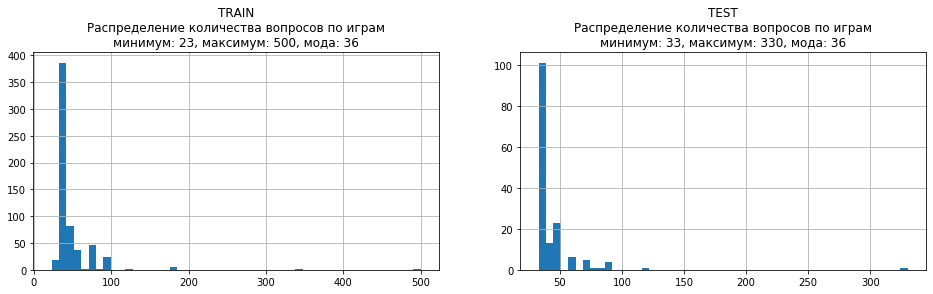

In [8]:
quest_num_train = [len(t["teams"][0]["mask"]) for t in train]
quest_num_test = [len(t["teams"][0]["mask"]) for t in test]


plot_stat(
    X1=quest_num_train, X2=quest_num_test, 
    title1="TRAIN\nРаспределение количества вопросов по играм", 
    title2="TEST\nРаспределение количества вопросов по играм", 
    bins=50, stat="mode"
)

**Доля правильных ответов**

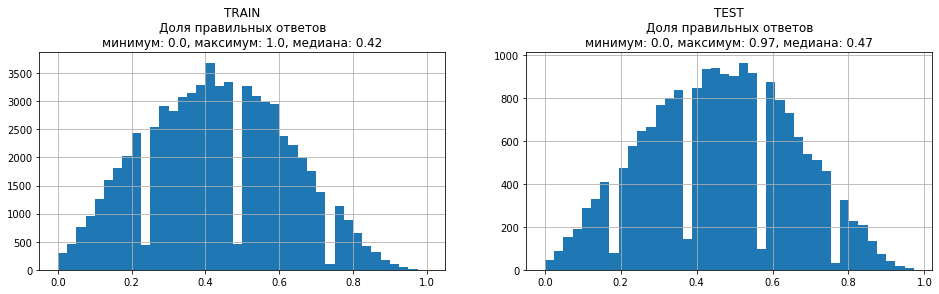

In [9]:
right_ans_rate_train = np.array([
    team["right_answers"] / len(team["mask"])
    for t in train 
    for team in t["teams"]
])
right_ans_rate_test = np.array([
    team["right_answers"] / len(team["mask"])
    for t in test 
    for team in t["teams"]
])

plot_stat(
    X1=right_ans_rate_train, X2=right_ans_rate_test, 
    title1="TRAIN\nДоля правильных ответов", 
    title2="TEST\nДоля правильных ответов", 
    bins=40, stat="median"
)

**Зависимость доли правильных ответов команды от среднего рейтинга игроков в этой команде**

In [10]:
rating_train = np.array([
    np.mean(team["rating"])
    for t in train 
    for team in t["teams"]
])
rating_test = np.array([
    np.mean(team["rating"]) 
    for t in test 
    for team in t["teams"]
])

rating_train[np.where(pd.isnull(rating_train))] = 0
rating_test[np.where(pd.isnull(rating_test))] = 0

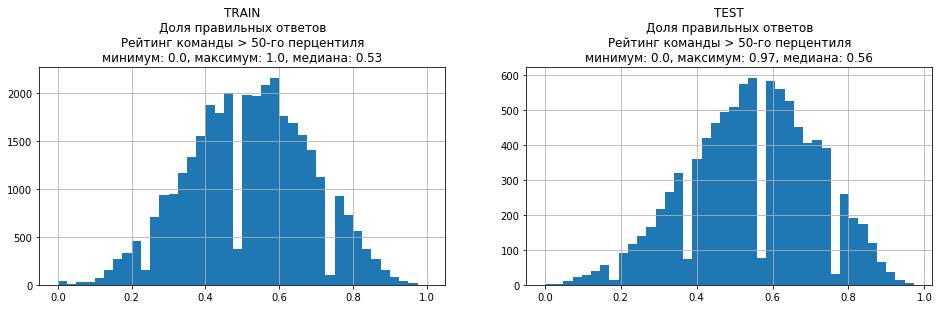

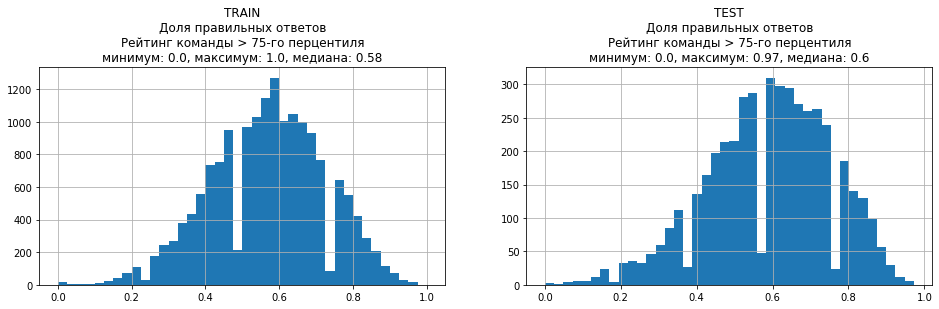

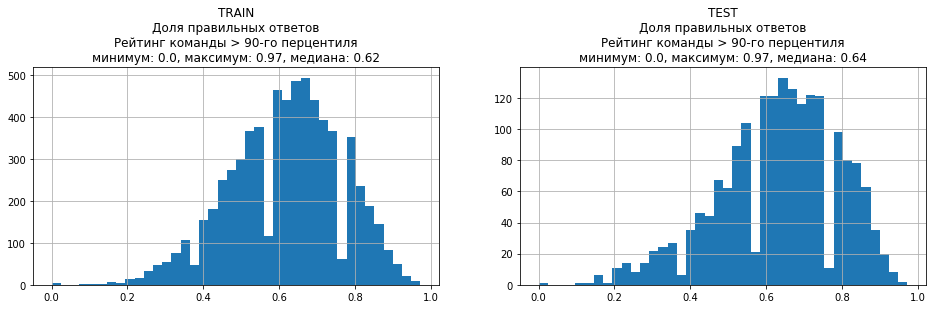

In [11]:
for q in [0.5, 0.75, 0.9]:
    plot_stat(
        X1=right_ans_rate_train[rating_train > np.quantile(rating_train, q)], 
        X2=right_ans_rate_test[rating_test > np.quantile(rating_test, q)],
        title1=f"TRAIN\nДоля правильных ответов\nРейтинг команды > {round(q*100)}-го перцентиля",
        title2=f"TEST\nДоля правильных ответов\nРейтинг команды > {round(q*100)}-го перцентиля",
        bins=40, stat="median"
    )

**Выводы**
* Большинство игр в обучающем и тестовом наборах данных состоят из 36 вопросов
* При увеличении среднего рейтинга игроков команды, медиана распределения доли правильных ответов увеличивается.

## Задание 2

Постройте baseline-модель на основе линейной или логистической регрессии, которая будет обучать рейтинг-лист игроков. Замечания и подсказки:
* повопросные результаты — это фактически результаты броска монетки, и их предсказание скорее всего имеет отношение к бинарной классификации;
* в разных турнирах вопросы совсем разного уровня сложности, поэтому модель должна это учитывать; скорее всего, модель должна будет явно обучать не только силу каждого игрока, но и сложность каждого вопроса;
* для baseline-модели можно забыть о командах и считать, что повопросные результаты команды просто относятся к каждому из её игроков.

**План действий**

> * Построим модель логистической регрессии. Соответствующие коэффициенты обученной модели и будут являться условной силой игроков или условной сложностью вопросов.
* В качестве основы признаков возьмем one-hot вектор для игроков
* Дополнительно рассмотрим one-hot вектор для вопросов, one-hot вектор для типа турнира и рейтинг игроков
* В качестве оцениваемой метрики на тесте будем использовать roc-auc. Для того, чтобы понять, уловила ли наша модель какую-то закономерность.
* Для простоты построения модели оставим игры с 36 вопросами

Построим 4 модельки и по качеству на тесте (и по результатам п.3) выбирем лучшую в качестве *baseline*. Может и некорректно так делать, но заодно проверим гипотезы в плане использования признаков.

In [6]:
# оставим игры с 36 вопросами

train36 = []
for t in train:
    if len(t["teams"][0]["mask"]) == 36:
        train36.append(t)
        
test36 = []
for t in test:
    if len(t["teams"][0]["mask"]) == 36:
        test36.append(t)
        
len(train36), len(test36)

(352, 100)

In [7]:
all_players_train = []
all_players_test = []

for t in train36:
    for team in t["teams"]:
        all_players_train.extend(team["members"])
        
unique_players_train = sorted(list(set(all_players_train)))
unique_tournament_type = set([t["tournament_type"] for t in train36])


print("Обучающая выборка")
print(f"- Суммарное количество игроков во всех играх: {len(all_players_train)}")
print(f"- Количество уникальных игроков: {len(unique_players_train)}")
print(f"- Количество уникальных типов игр: {len(unique_tournament_type)}")

Обучающая выборка
- Суммарное количество игроков во всех играх: 268499
- Количество уникальных игроков: 49218
- Количество уникальных типов игр: 4


In [8]:
# Посчитаем количество игроков в тестовой выборке таких, что они есть и в обучающей. 
# Т.к. если до этого модель не видела игрока, вряд ли она что-то хорошее предскажет

all_players_test = []

for t in test36:
    for team in t["teams"]:
        all_players_test.extend([member for member in team["members"] if member in unique_players_train])
        
unique_players_test = sorted(list(set(all_players_test)))

print("Тестовая выборка. Сводка по игрокам, которые есть и в обучающей выборке.")
print(f"- Суммарное количество игроков во всех играх: {len(all_players_test)}")
print(f"- Количество уникальных игроков: {len(unique_players_test)}")

Тестовая выборка. Сводка по игрокам, которые есть и в обучающей выборке.
- Суммарное количество игроков во всех играх: 68046
- Количество уникальных игроков: 19977


In [9]:
# id игроков идут не по порядку, поэтому преобразуем так, 
# чтобы номера их шли от нуля с шагом 1 и запомним это соответствие

id_player_to_order = {id_: i for i, id_ in enumerate(unique_players_train)}
order_to_player_id = {i: id_ for i, id_ in enumerate(unique_players_train)}

# аналогично для типов турниров
tournament_type_to_order = {id_: i for i, id_ in enumerate(unique_tournament_type)}
order_to_tournament_type = {i: id_ for i, id_ in enumerate(unique_tournament_type)}

In [7]:
def split_data(train_data, test_data, feat_type=0):
    """Выдача X_train, y_train, X_test, y_test.
        
        feat_type=0: используем только one-hot вектор игроков
        feat_type=1: используем one-hot вектор игроков + one-hot вектор типа игры
        feat_type=2: используем one-hot вектор игроков + one-hot вектор типа игры + рейтинг игрока
        feat_type=3: используем one-hot вектор игроков + one-hot вопросов
    """
    
    step = 36
    
    # кол-во признаков
    if feat_type == 0:
        col_ = len(unique_players_train)
    elif feat_type == 1:
        col_ = len(unique_players_train) + len(unique_tournament_type)
    elif feat_type == 2:
        col_ = len(unique_players_train) + len(unique_tournament_type) + 1
    elif feat_type == 3:
        col_ = len(unique_players_train) + len(train36) * step
    else:
        raise NotImplementedError
    
    
    ##########################################
    ### train
    ##########################################
    
    # кол-во объектов - суммарное количество игроков во всех играх
    row_ = 36 * len(all_players_train)
    
    if feat_type == 2:
        X_train = lil_matrix((row_, col_), dtype=np.float)
    else:
        X_train = lil_matrix((row_, col_), dtype=np.int8)
    y_train = np.zeros(row_)

    i, j = 0, len(unique_players_train)
    rating = []

    for t in tqdm(train_data):
        
        tournament = tournament_type_to_order[t["tournament_type"]]
    
        for team in t["teams"]:
            
            # список ответов
            mask = list(map(int, list(team["mask"])))
            # список порядковых номеров игроков
            members = [id_player_to_order[member] for member in team["members"]]
            
            for k, member in enumerate(members):
                X_train[i:i+step, member] = 1
                y_train[i:i+step] = mask
                
                if feat_type == 1:
                    X_train[i:i+step, j + tournament] = 1
                    
                if feat_type == 2:
                    rating.extend([team["rating"][k], ] * step)
                    
                if feat_type == 3:
                    X_train[i:i+step, np.arange(j, j + step)] = 1
                
                i += step
                
        if feat_type == 3:
            j += step
    
    # нормировка рейтинга
    if feat_type == 2:
        rating_mean = np.median(rating)
        rating_std = np.std(rating)
        rating_norm = (np.array(rating) - rating_mean) / rating_std
        X_train[:, -1] = rating_norm
        
    
    
    
    ##########################################
    # test
    ##########################################
    
    # кол-во объектов - суммарное количество игроков во всех играх
    row_ = 36 * len(all_players_test)
    
    if feat_type == 2:
        X_test = lil_matrix((row_, col_), dtype=np.float)
    else:
        X_test = lil_matrix((row_, col_), dtype=np.int8)
    y_test = np.zeros(row_)
    
    i, j = 0, len(unique_players_test)
    rating = []

    for t in tqdm(test_data):
        
        tournament = tournament_type_to_order[t["tournament_type"]]
    
        for team in t["teams"]:
            
            # список ответов
            mask = list(map(int, list(team["mask"])))
            # список порядковых номеров игроков
            members = [id_player_to_order[member] for member in team["members"] if member in unique_players_test]
            
            for k, member in enumerate(members):
                X_test[i:i+step, member] = 1
                y_test[i:i+step] = mask
                
                if feat_type == 1:
                    X_test[i:i+step, j + tournament] = 1
                    
                if feat_type == 2:
                    rating.extend([team["rating"][k], ] * step)
                    
                if feat_type == 3:
                    # вопросы другие, значит здесь будут нули
                    pass
                
                i += step
    
    # нормировка рейтинга
    if feat_type == 2:
        rating_norm = (np.array(rating) - rating_mean) / rating_std
        X_test[:, -1] = rating_norm
        
    return X_train, y_train, X_test, y_test

**Модель 1.**

В качестве признаков one-hot вектор игроков

In [54]:
X_train, y_train, X_test, y_test = split_data(train36, test36, feat_type=0)

100%|██████████| 100/100 [00:40<00:00,  2.49it/s]


In [55]:
model1 = LogisticRegression(max_iter=1000)
model1.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [56]:
y_pred = model1.predict_proba(X_test)[:, 1]
score1 = roc_auc_score(y_test, y_pred)

print(f"roc_auc: {round(score1, 2)}")

roc_auc: 0.62


**Модель 2.**

В качестве признаков one-hot вектор игроков + one-hot вектор типа турнира

In [58]:
X_train, y_train, X_test, y_test = split_data(train36, test36, feat_type=1)

100%|██████████| 100/100 [00:53<00:00,  1.87it/s]


In [63]:
model2 = LogisticRegression(max_iter=1000)
model2.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [64]:
y_pred = model2.predict_proba(X_test)[:, 1]
score2 = roc_auc_score(y_test, y_pred)

print(f"roc_auc: {round(score2, 2)}")

roc_auc: 0.58


**Модель 3.**

В качестве признаков one-hot вектор игроков + one-hot вектор типа турнира + рейтинг игроков

In [65]:
X_train, y_train, X_test, y_test = split_data(train36, test36, feat_type=2)

100%|██████████| 100/100 [00:39<00:00,  2.53it/s]


In [66]:
model3 = LogisticRegression(max_iter=1000)
model3.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [67]:
y_pred = model3.predict_proba(X_test)[:, 1]
score3 = roc_auc_score(y_test, y_pred)

print(f"roc_auc: {round(score3, 2)}")

roc_auc: 0.62


**Модель 4.**

В качестве признаков one-hot вектор игроков + one-hot вектор вопросов

In [11]:
X_train, y_train, X_test, y_test = split_data(train36, test36, feat_type=3)

100%|██████████| 100/100 [00:43<00:00,  2.31it/s]


In [12]:
model4 = LogisticRegression(tol=1e-1, solver="saga", C=1)
model4.fit(X_train, y_train)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='saga', tol=0.1, verbose=0,
                   warm_start=False)

In [13]:
y_pred = model4.predict_proba(X_test)[:, 1]
score4 = roc_auc_score(y_test, y_pred)

print(f"roc_auc: {round(score4, 2)}")

roc_auc: 0.62


**Выводы:**
* Качество на тесте получилось везде примерно одинаковое: порядка 0.62. Не вау, но, по крайней мере, больше 0.5. Значит модели хоть какую-то закономерность уловили.
* У второй модели, где в качестве признаков использовался дополнительно тип игры - качество чуть ниже. Эту модель далее рассматривать не будем.
* У трех оставшихся моделей метрики качества совпадают: это говорит о том, что признак *one-hot вектор игрока* превалирующую роль играет.
* В 4-й модели еще учитывается "сложность" вопросов. Хотя сложность вопросов мы можем оценить только на обучающей выборке. Но получается, что "сила" игроков (коэффициенты лог. регрессии) как бы перевзвешиваются с учетом сложности вопросов.
* В качестве "силы" игроков и "сложности" вопросов будем использовать соответствующие коэффициенты получившейся логистической регрессии.

Далее остановимся на 4-й модели, т.к. чуть получше дала результаты в **п.3** для корреляций

## Задание 3

Качество рейтинг-системы оценивается качеством предсказаний результатов турниров. Но сами повопросные результаты наши модели предсказывать вряд ли смогут, ведь неизвестно, насколько сложными окажутся вопросы в будущих турнирах; да и не нужны эти предсказания сами по себе. Поэтому:
* предложите способ предсказать результаты нового турнира с известными составами, но неизвестными вопросами, в виде ранжирования команд;
* в качестве метрики качества на тестовом наборе давайте считать ранговые корреляции Спирмена и Кендалла (их можно взять в пакете scipy) между реальным ранжированием в результатах турнира и предсказанным моделью, усреднённые по тестовому множеству турниров.


>* Далее будем оценивать "силу" одного игрока, как соответствующий коэффициент обученной логистической регрессии. 
* "Силу" команды - как среднее значение "силы" всех игроков. 
* Прогноз результата игры: отранжированные по "силе" команды.

In [17]:
def get_corr(coef):
    """Расчет ранговых корреляций Спирмена и Кендалла на тесте."""

    order_real = []
    order_pred = []

    for t in test36:

        rating_real = []
        rating_pred = []

        for i, team in enumerate(t["teams"]):

            members = [
                coef[id_player_to_order[member]]
                for member in team["members"] 
                if member in unique_players_test
            ]

            if len(members) == 0:
                continue

            rating_real.append(i)
            rating_pred.append(np.mean(members))

        if len(rating_real) == 0:
            continue

        order_real.append(rating_real)
        order_pred.append(np.argsort(rating_pred)[::-1])


    spearmanr_coef = np.mean([stats.spearmanr(a, b)[0] for a, b in zip(order_real, order_pred)])
    kendalltau_coef = np.mean([stats.kendalltau(a, b)[0] for a, b in zip(order_real, order_pred)])
    
    return {"spearmanr": spearmanr_coef, "kendalltau": kendalltau_coef}

In [49]:
corr = get_corr(model4.coef_[0])

print(f"\n-> Ранговая корреляция Спирмена: {round(corr['spearmanr'], 4)}")
print(f"\n-> Ранговая корреляция Кендалла: {round(corr['kendalltau'], 4)}\n")


-> Ранговая корреляция Спирмена: 0.7525

-> Ранговая корреляция Кендалла: 0.5814



**Выводы:**
* ранговая корреляция Спирмена получилась равной ${\sim0,75}$
* ранговая корреляция Кендалла получилась равной ${\sim0,58}$

## Задание 4

Теперь главное: ЧГК — это всё-таки командная игра. Поэтому:
* предложите способ учитывать то, что на вопрос отвечают сразу несколько игроков; скорее всего, понадобятся скрытые переменные; не стесняйтесь делать упрощающие предположения, но теперь переменные “игрок X ответил на вопрос Y” при условии данных должны стать зависимыми для игроков одной и той же команды;
* разработайте EM-схему для обучения этой модели, реализуйте её в коде;
* обучите несколько итераций, убедитесь, что целевые метрики со временем растут (скорее всего, ненамного, но расти должны), выберите лучшую модель, используя целевые метрики.


Вероятность правильного ответа игрока при условии правильного ответа команды распишем по теореме Байеса:

$${p(игрок=1|команда=1) = \frac {p(игрок=1) \cdot p(команда=1|игрок=1)}{p(команда=1)}}$$


- **E-шаг:** оцениваем вероятность ${p(игрок=1|команда=1)}$


- **М-шаг:** переобучаем модель на новых вероятностях


*Пояснения:*

* ${p(игрок=1)}$ - априорная вероятность, которую берем равной вероятности правильного ответа игроком из результа предсказания нашей обученной модели

* ${p(игрок=1)}$ - вероятность правильного ответа команды. Но т.к. мы знаем, ответила команда или нет, то для правильных ответов данная вероятность будет равно 1.

* ${p(команда=1|игрок=1)}$ - вероятность того, что игрок правильно ответил и команда приняла его версию. Здесь будем оценивать вероятность, как средний вес игрока по команде с учетом его "силы", которую предсказывает обученная модель. Чем более сильный игрок, тем команда вероятнее примет его версию.

In [84]:
# id игроков по командам
players_train_id = [team["members"] for t in train36 for team in t["teams"]]

In [85]:
def get_prob_prior(y):
    """Расчет априорных вероятностей."""
    return 1 - 1. / (1 + np.exp(-y))
    

def E_step(prob_prior, coef, y_real):
    """Расчет новых меток для регрессии."""
    
    # макс. правдоподобие
    mle = np.zeros_like(prob_prior)
    
    i = 0
    step = 36
    for team in players_train_id:
        
        players_weight = np.array([coef[id_player_to_order[member]] for member in team])
        players_weight[players_weight < 0] = 0
        
        if players_weight.sum() == 0:
            players_weight = np.ones_like(players_weight)
        players_weight = np.ones_like(players_weight)
        
        players_weight_norm = players_weight / players_weight.sum()
        
        for w in players_weight_norm:
            mle[i:i+step] = w
            i += step
    
    # умножение на y_real идет, чтобы обнулить метки там, 
    # где мы знаем, что команда не ответила
    prob_posterior = prob_prior * mle * y_real
    # prob_posterior = prob_prior * y_real
    
    z = np.log(prob_posterior / (1 - prob_posterior) + 1e-6)
    
    return z

In [86]:
regr = Ridge(alpha=1, solver='sparse_cg')

prob_prior = model4.predict_proba(X_train)[:, 1]

for i in range(5):
    
    print(f"iter#{i+1}:    ", end="")
    
    # E шаг
    print("E-step...    ", end="")
    if i == 0:
        z = E_step(prob_prior, model4.coef_[0], y_train)
    else:
        prob_prior = get_prob_prior(y_pred)
        z = E_step(prob_prior, regr.coef_, y_train)
    
    # M шаг
    print("M-step...", end="\n")
    
    regr.fit(X_train, z)
    
    # метрики
    corr = get_corr(regr.coef_)
    
    print("Metrics:")
    print(f"---> 'spearmanr':  {round(corr['spearmanr'], 4)}")
    print(f"---> 'kendalltau': {round(corr['kendalltau'], 4)}")
    print()
    
    y_pred = regr.predict(X_train)

iter#1:    E-step...    M-step...
Metrics:
---> 'spearmanr':  0.7564
---> 'kendalltau': 0.588

iter#2:    E-step...    M-step...
Metrics:
---> 'spearmanr':  0.7554
---> 'kendalltau': 0.587

iter#3:    E-step...    M-step...
Metrics:
---> 'spearmanr':  0.7556
---> 'kendalltau': 0.5873

iter#4:    E-step...    M-step...
Metrics:
---> 'spearmanr':  0.7556
---> 'kendalltau': 0.5871

iter#5:    E-step...    M-step...
Metrics:
---> 'spearmanr':  0.7556
---> 'kendalltau': 0.5871



**Выводы:**

* Предсказание с точки зрения ранговых корреляций улучшилось буквально в 3-м знаке после запятой.

* При этом видно, что на втором шаге ранговые корреляции увеличиваются, а потом не растут. Возможно, это связано с тем, что модель могла сойтись за одну итерацию. На 4-й и 5-ой итерациях метрики перестают меняться. При этом результат сильно зависит от выставляемой точности. Но при увеличении точности очень долго расчет идет...

* Попробовал промоделировать случай, когда ${p(команда=1|игрок=1) = 1}$, т.е. если игрок предложил правильную версию, то команда обязательно ее выберет. Результаты качественно получились такими же.

## Задание 5

А что там с вопросами? Постройте “рейтинг-лист” турниров по сложности вопросов. Соответствует ли он интуиции (например, на чемпионате мира в целом должны быть сложные вопросы, а на турнирах для школьников — простые)? Если будет интересно: постройте топ сложных и простых вопросов со ссылками на конкретные записи в базе вопросов ЧГК (это чисто техническое дело, тут никакого ML нету).

**Рейтинг турниров baseline-модели**

In [67]:
tournament_rating = [
    np.mean(model4.coef_[0][i:i+36]) 
    for i in range(len(unique_players_train), X_train.shape[1], 36)
]

tournament_order = np.argsort(tournament_rating)[::-1]

tournament_name = [
    tournaments[train36[i]["id"]]["name"] 
    for i in tournament_order
]

df_tournament = pd.DataFrame({
    "Наименование турнира": tournament_name,
    "Условный рейтинг (сложность вопросов)": np.sort(tournament_rating)[::-1]
})

Первые 10 турниров по средней сложности вопросов

In [74]:
df_tournament.head(10)

,Наименование турнира,Условный рейтинг (сложность вопросов)
0,(а)Синхрон-lite. Лига старта. Эпизод V,1.197257
1,(а)Синхрон-lite. Лига старта. Эпизод X,0.975768
2,(а)Синхрон-lite. Лига старта. Эпизод III,0.962551
3,(а)Синхрон-lite. Лига старта. Эпизод IX,0.925852
4,Второй тематический турнир имени Джоуи Триббиани,0.889426
5,(а)Синхрон-lite. Лига старта. Эпизод VII,0.851431
6,Межфакультетский кубок МГУ. Отбор №4,0.821586
7,Турнир малых факультетов МГУ,0.805268
8,(а)Синхрон-lite. Лига старта. Эпизод VI,0.788786
9,[18+] Болтик в гаечку,0.760821


Последние 10 турниров по средней сложности вопросов

In [76]:
df_tournament.tail(10)

,Наименование турнира,Условный рейтинг (сложность вопросов)
342,Записки охотника,-1.693337
343,Тихий Донец: омут первый,-1.694044
344,Воображаемый музей,-1.711905
345,"Ра-II: синхрон ""Борского корабела""",-1.714863
346,VERSUS: Коробейников vs. Матвеев,-1.725410
347,Ускользающая сова,-1.746946
348,Чемпионат Минска. Лига А. Тур четвёртый,-1.754353
349,Зеркало мемориала памяти Михаила Басса,-1.754840
350,Знание – Сила VI,-1.822086
351,Первенство правого полушария,-2.243688


**Рейтинг турниров EM-модели**

In [87]:
tournament_rating = [
    np.mean(regr.coef_[i:i+36]) 
    for i in range(len(unique_players_train), X_train.shape[1], 36)
]

tournament_order = np.argsort(tournament_rating)[::-1]

tournament_name = [
    tournaments[train36[i]["id"]]["name"] 
    for i in tournament_order
]

df_tournament = pd.DataFrame({
    "Наименование турнира": tournament_name,
    "Условный рейтинг (сложность вопросов)": np.sort(tournament_rating)[::-1]
})

Первые 10 турниров по средней сложности вопросов

In [88]:
df_tournament.head(10)

,Наименование турнира,Условный рейтинг (сложность вопросов)
0,(а)Синхрон-lite. Лига старта. Эпизод V,0.137746
1,(а)Синхрон-lite. Лига старта. Эпизод III,0.125593
2,(а)Синхрон-lite. Лига старта. Эпизод VII,0.124104
3,Школьная лига. I тур.,0.123410
4,Школьная лига. III тур.,0.122989
5,Школьный Синхрон-lite. Выпуск 2.5,0.122913
6,(а)Синхрон-lite. Лига старта. Эпизод IX,0.121207
7,Школьная лига. II тур.,0.115384
8,(а)Синхрон-lite. Лига старта. Эпизод IV,0.112998
9,Межфакультетский кубок МГУ. Отбор №4,0.110537


Последние 10 турниров по средней сложности вопросов

In [89]:
df_tournament.tail(10)

,Наименование турнира,Условный рейтинг (сложность вопросов)
342,Чемпионат Минска. Лига А. Тур второй,-0.090908
343,Серия Premier. Седьмая печать,-0.091194
344,Львов зимой. Адвокат,-0.093298
345,Зеркало мемориала памяти Михаила Басса,-0.102600
346,Знание – Сила VI,-0.102636
347,Ускользающая сова,-0.103769
348,Записки охотника,-0.104776
349,Чемпионат Минска. Лига А. Тур четвёртый,-0.105636
350,Первенство правого полушария,-0.113755
351,Воображаемый музей,-0.113873


**Выводы:**

* Тут первая некорректность всплыла, что оставил игры с 36 вопросами. Получается, чемпионаты мира не попали, как минимум.


* И похоже, что плохо турниры по сложности вопросов отсортировались. В результах, полученных из EM-алгоритма, аж 3 школьных игры в топ10 попали. А чемпионат Минска в последнем десятке наоборот.

## Задание 6

*Бонус:* постройте топ игроков по предсказанной вашей моделью силе игры, а рядом с именами игроков напишите общее число вопросов, которое они сыграли. Скорее всего, вы увидите, что топ занят игроками, которые сыграли совсем мало вопросов, около 100 или даже меньше; если вы поищете их в официальном рейтинге ЧГК, вы увидите, что это какие-то непонятные ноунеймы. В baseline-модели, скорее всего, такой эффект будет гораздо слабее.

Это естественное свойство модели: за счёт EM-схемы влияние 1-2 удачно сыгранных турниров будет только усиливаться, потому что неудачных турниров, чтобы его компенсировать, у этих игроков нет. Более того, это не мешает метрикам качества, потому что если эти игроки сыграли всего 1-2 турнира в 2019-м, скорее всего они ничего или очень мало сыграли и в 2020, и их рейтинги никак не влияют на качество тестовых предсказаний. Но для реального рейтинга такое свойство, конечно, было бы крайне нежелательным. Давайте попробуем его исправить:
* сначала жёстко: выберите разумную отсечку по числу вопросов, учитывая, что в одном турнире их обычно 30-50;
можно ли просто выбросить игроков, которые мало играли, и переобучить модель? почему? предложите, как нужно изменить модель, чтобы не учитывать слишком мало сыгравших, и переобучите модель;
* но всё-таки это не слишком хорошее решение: если выбрать маленькую отсечку, будут ноунеймы в топе, а если большую, то получится, что у нового игрока слишком долго не будет рейтинга; скорее всего, никакой “золотой середины” тут не получится;
* предложите более концептуальное решение для топа игроков в рейтинг-листе; если получится, реализуйте его на практике (за это уж точно будут серьёзные бонусные баллы).


**Построим только топ-игроков**

In [92]:
import collections

freq = collections.Counter(all_players_train)

In [111]:
player_name = []
player_tournaments_count = []
player_rating = []

for pl_id in freq:
    player_name.append(f"{players[pl_id]['surname']} {players[pl_id]['name']} {players[pl_id]['patronymic']}")
    player_tournaments_count.append(freq[pl_id])
    player_rating.append(model4.coef_[0][id_player_to_order[pl_id]])
    
df_players = pd.DataFrame({
    "Игрок": player_name, 
    "Количество игр": player_tournaments_count, 
    "Число вопросов": np.array(player_tournaments_count) * 36, 
    "Условный рейтинг": player_rating
})

df_players = df_players.sort_values(
    by="Условный рейтинг", ascending=False
).reset_index(drop=True)

**Топ-15 игров по версии baseline-модели**

In [113]:
df_players.head(15)

,Игрок,Количество игр,Число вопросов,Условный рейтинг
0,Руссо Максим Михайлович,29,1044,2.823395
1,Савченков Михаил Владимирович,39,1404,2.783042
2,Семушин Иван Николаевич,53,1908,2.744875
3,Сорожкин Артём Сергеевич,69,2484,2.703317
4,Брутер Александра Владимировна,36,1296,2.688913
5,Спешков Сергей Леонидович,44,1584,2.674418
6,Прокофьева Ирина Сергеевна,7,252,2.585083
7,Пашковский Евгений Александрович,16,576,2.566497
8,Саксонов Антон Владимирович,20,720,2.544706
9,Николенко Сергей Игоревич,24,864,2.530892


In [115]:
player_name = []
player_tournaments_count = []
player_rating = []

for pl_id in freq:
    player_name.append(f"{players[pl_id]['surname']} {players[pl_id]['name']} {players[pl_id]['patronymic']}")
    player_tournaments_count.append(freq[pl_id])
    player_rating.append(regr.coef_[id_player_to_order[pl_id]])
    
df_players = pd.DataFrame({
    "Игрок": player_name, 
    "Количество игр": player_tournaments_count, 
    "Число вопросов": np.array(player_tournaments_count) * 36, 
    "Условный рейтинг": player_rating
})

df_players = df_players.sort_values(
    by="Условный рейтинг", ascending=False
).reset_index(drop=True)

**Топ-15 игров по версии EM-модели**

In [116]:
df_players.head(15)

,Игрок,Количество игр,Число вопросов,Условный рейтинг
0,Руссо Максим Михайлович,29,1044,7.849654
1,Семушин Иван Николаевич,53,1908,7.767524
2,Савченков Михаил Владимирович,39,1404,7.756746
3,Брутер Александра Владимировна,36,1296,7.641547
4,Летюхина Мария Алексеевна,3,108,7.508455
5,Царёв Михаил Сергеевич,3,108,7.508334
6,Спешков Сергей Леонидович,44,1584,7.507270
7,Пилипенко Максим Игоревич,1,36,7.507080
8,Мартынов Александр Ефимович,15,540,7.464076
9,Резникова Анна Григорьевна,1,36,7.426328


**Выводы по рейтингу игроков:**

* Здесь уже результаты, на мой взгляд, неплохие. По крайней мере, в топе много людей, которые легко гуглятся (как, например, игроки Своей Игры) и на 2022 имеют достаточно высокие позиции (в первой или втором десятке).

* Автор курса и домашнего задания Сергей Николенко попал на 9 и 14 места соответственно.

## Задание 7

*Бонус:* игроки со временем учатся играть лучше (а иногда бывает и наоборот). А в нашей модели получается, что первые неудачные турниры новичка будут тянуть его рейтинг вниз всю жизнь — это нехорошо, рейтинг должен быть достаточно гибким и иметь возможность меняться даже у игроков, отыгравших сотни турниров. Давайте попробуем этого добиться:
* если хватит вычислительных ресурсов, сначала сделайте baseline совсем без таких схем, обучив рейтинги на всех турнирах с повопросными результатами, а не только на турнирах 2019 года; улучшилось ли качество предсказаний на 2020?
* одну схему со временем мы уже использовали: брали для обучения только последний год турниров; примерно так делают, например, в теннисной чемпионской гонке; у этой схемы есть свои преимущества, но есть и недостатки (например, достаточно мало играть год, чтобы полностью пропасть из рейтинга);
* предложите варианты базовой модели или алгоритма её обучения, которые могли бы реализовать изменения рейтинга со временем; если получится, реализуйте их на практике, проверьте, улучшатся ли предсказания на 2020.


Попробуем обучить модель на всех играх до 2019 включительно и посмотреть на качество предсказания на играх 2020 года

In [9]:
TRAIN_YEAR = 2019

# id игр, которые подходят по дате для формирования тренировочного и тестового наборов
ids_train = [
    idx 
    for idx in tournaments.keys() 
    if pd.Timestamp(tournaments[idx]['dateStart']).date().year <= TRAIN_YEAR
]

train = get_data(ids_train)

In [10]:
# оставим игры с 36 вопросами
train36 = []
for t in train:
    if len(t["teams"][0]["mask"]) == 36:
        train36.append(t)
        
len(train36)

1275

In [11]:
all_players_train = []
all_players_test = []

for t in train36:
    for team in t["teams"]:
        all_players_train.extend(team["members"])
        
unique_players_train = sorted(list(set(all_players_train)))
unique_tournament_type = set([t["tournament_type"] for t in train36])


print("Обучающая выборка")
print(f"- Суммарное количество игроков во всех играх: {len(all_players_train)}")
print(f"- Количество уникальных игроков: {len(unique_players_train)}")
print(f"- Количество уникальных типов игр: {len(unique_tournament_type)}")

Обучающая выборка
- Суммарное количество игроков во всех играх: 876537
- Количество уникальных игроков: 107894
- Количество уникальных типов игр: 5


In [12]:
# Посчитаем количество игроков в тестовой выборке таких, что они есть и в обучающей. 
# Т.к. если до этого модель не видела игрока, вряд ли она что-то хорошее предскажет

all_players_test = []

for t in test36:
    for team in t["teams"]:
        all_players_test.extend([member for member in team["members"] if member in unique_players_train])
        
unique_players_test = sorted(list(set(all_players_test)))

print("Тестовая выборка. Сводка по игрокам, которые есть и в обучающей выборке.")
print(f"- Суммарное количество игроков во всех играх: {len(all_players_test)}")
print(f"- Количество уникальных игроков: {len(unique_players_test)}")

Тестовая выборка. Сводка по игрокам, которые есть и в обучающей выборке.
- Суммарное количество игроков во всех играх: 69190
- Количество уникальных игроков: 20758


In [13]:
id_player_to_order = {id_: i for i, id_ in enumerate(unique_players_train)}
order_to_player_id = {i: id_ for i, id_ in enumerate(unique_players_train)}

tournament_type_to_order = {id_: i for i, id_ in enumerate(unique_tournament_type)}
order_to_tournament_type = {i: id_ for i, id_ in enumerate(unique_tournament_type)}

In [14]:
X_train, y_train, X_test, y_test = split_data(train36, test36, feat_type=3)

100%|██████████| 100/100 [00:43<00:00,  2.30it/s]


In [24]:
model5 = LogisticRegression(tol=1e-1, solver="saga", C=1)
model5.fit(X_train, y_train)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='saga', tol=0.001, verbose=0,
                   warm_start=False)

In [25]:
corr = get_corr(model5.coef_[0])

print(f"\n-> Ранговая корреляция Спирмена: {round(corr['spearmanr'], 4)}")
print(f"\n-> Ранговая корреляция Кендалла: {round(corr['kendalltau'], 4)}\n")


-> Ранговая корреляция Спирмена: 0.7421

-> Ранговая корреляция Кендалла: 0.573



In [27]:
freq = collections.Counter(all_players_train)

player_name = []
player_tournaments_count = []
player_rating = []

for pl_id in freq:
    player_name.append(f"{players[pl_id]['surname']} {players[pl_id]['name']} {players[pl_id]['patronymic']}")
    player_tournaments_count.append(freq[pl_id])
    player_rating.append(model5.coef_[0][id_player_to_order[pl_id]])
    
df_players = pd.DataFrame({
    "Игрок": player_name, 
    "Количество игр": player_tournaments_count, 
    "Число вопросов": np.array(player_tournaments_count) * 36, 
    "Условный рейтинг": player_rating
})

df_players = df_players.sort_values(
    by="Условный рейтинг", ascending=False
).reset_index(drop=True)

Рейтинг игроков

In [28]:
df_players.head(20)

,Игрок,Количество игр,Число вопросов,Условный рейтинг
0,Руссо Максим Михайлович,93,3348,3.131068
1,Брутер Александра Владимировна,130,4680,2.997509
2,Прокофьева Ирина Сергеевна,44,1584,2.980714
3,Семушин Иван Николаевич,159,5724,2.974682
4,Тяпин Дмитрий Владимирович,2,72,2.966133
5,Гришов Юрий Александрович,3,108,2.905043
6,Савченков Михаил Владимирович,158,5688,2.888112
7,Сорожкин Артём Сергеевич,182,6552,2.852575
8,Новиков Илья Сергеевич,59,2124,2.844309
9,Мурашковский Алексей Юльевич,3,108,2.818172


**Выводы по baseline-модели:**

* Везде лидирует Руссо Михаил:)


* Результаты предсказаний, если смотреть на ранговые метрики, не поменялись. Топ игроков плюс-минус такой же.